In [2]:
pip install tensorflow transformers

In [3]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import demoji
import re
import string
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [6]:
TWITTER_DATA =  pd.read_csv("/content/twitter_training.csv", header=None)

# Define column names
column_names = ['ID', 'Game', 'Sentiment', 'Text']

# Add column names to the DataFrame
TWITTER_DATA.columns = column_names

# Display the updated DataFrame with column names
TWITTER_DATA.head(5) # Display the first five rows of the DataFrame

,ID,Game,Sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
TWITTER_DATA.drop(['ID', 'Game'],axis=1,inplace=True)

In [8]:
TWITTER_DATA

,Sentiment,Text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


In [9]:
print(f"the length of training dataset if {len(TWITTER_DATA)}")

the length of training dataset if 74682


In [10]:
# Print basic information about the TWITTER_DATA object, like its size, data type, or structure., NULL VALUES ATC
TWITTER_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  74682 non-null  object
 1   Text       73996 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


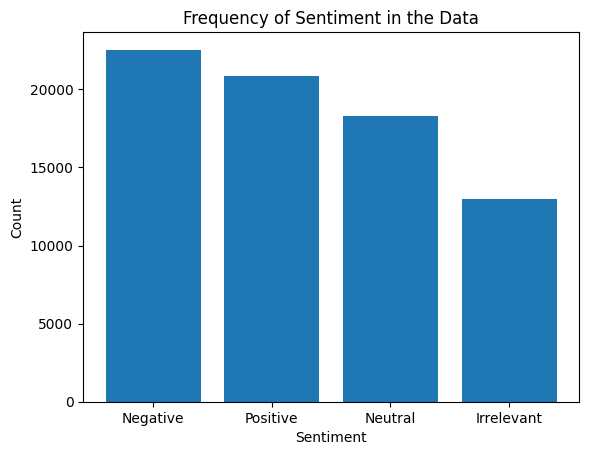

In [11]:
import matplotlib.pyplot as plt
# Count the occurrences of each unique value
color_counts =TWITTER_DATA['Sentiment'].value_counts()

# Create a bar chart
plt.bar(color_counts.index, color_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Frequency of Sentiment in the Data')
plt.show()

# ***Data Preprocessing***

In [12]:
TWITTER_DATA

,Sentiment,Text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


In [13]:
# Function to remove emojis from text
def remove_emojis(text):
    if isinstance(text, str):  # Check if text is a string
        return demoji.replace(text, "")
    else:
        return text  # Return as is if not a string

# Function to convert text to lowercase
def convert_to_lower(text):
    if isinstance(text, str):  # Check if text is a string
        return text.lower()
    else:
        return ""  # Return empty string for non-string values

# Function to remove repeating characters
def cleaning_repeating_char(text):
    if isinstance(text, str):  # Check if text is a string
        return re.sub(r'(.)\1+', r'\1', text)
    else:
        return ""  # Return empty string for non-string values

# Function to remove numbers from text
def cleaning_numbers(text):
    if isinstance(text, str):  # Check if text is a string
        return re.sub(r'\d+', '', text)
    else:
        return ""  # Return empty string for non-string values

# Function to remove punctuation from text
def cleaning_punctuations(text):
    if isinstance(text, str):  # Check if text is a string
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)
    else:
        return ""  # Return empty string for non-string values


In [14]:
# Apply text cleaning functions to the 'Text' column
TWITTER_DATA['Text'] = TWITTER_DATA['Text'].apply(lambda x: remove_emojis(str(x)))
TWITTER_DATA['Text'] = TWITTER_DATA['Text'].apply(lambda x: convert_to_lower(x))
TWITTER_DATA['Text'] = TWITTER_DATA['Text'].apply(lambda x: cleaning_repeating_char(x))
TWITTER_DATA['Text'] = TWITTER_DATA['Text'].apply(lambda x: cleaning_numbers(x))
TWITTER_DATA['Text'] = TWITTER_DATA['Text'].apply(lambda x: cleaning_punctuations(x))

In [15]:
TWITTER_DATA

,Sentiment,Text
0,Positive,im geting on borderlands and i wil murder you al
1,Positive,i am coming to the borders and i wil kil you al
2,Positive,im geting on borderlands and i wil kil you al
3,Positive,im coming on borderlands and i wil murder you al
4,Positive,im geting on borderlands and i wil murder you...
...,...,...
74677,Positive,just realized that the windows partition of my...
74678,Positive,just realized that my mac window partition is ...
74679,Positive,just realized the windows partition of my mac ...
74680,Positive,just realized betwen the windows partition of ...


In [16]:
import nltk

# Download the stopwords for English (or any other language supported by NLTK)
nltk.download('stopwords')

# Access the stopwords list
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [17]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


In [18]:
TWITTER_DATA['Text'] = TWITTER_DATA['Text'].apply(lambda text: cleaning_stopwords(text))
TWITTER_DATA['Text'].head()

0    im geting borderlands wil murder al
1              coming borders wil kil al
2       im geting borderlands wil kil al
3    im coming borderlands wil murder al
4    im geting borderlands wil murder al
Name: Text, dtype: object

In [19]:
TWITTER_DATA

,Sentiment,Text
0,Positive,im geting borderlands wil murder al
1,Positive,coming borders wil kil al
2,Positive,im geting borderlands wil kil al
3,Positive,im coming borderlands wil murder al
4,Positive,im geting borderlands wil murder al
...,...,...
74677,Positive,realized windows partition mac like years behi...
74678,Positive,realized mac window partition years behind nvi...
74679,Positive,realized windows partition mac years behind nv...
74680,Positive,realized betwen windows partition mac like yea...


In [20]:
# CLEANING AND REMOVING REPEATING CHARACTER
import re
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
TWITTER_DATA['Text'] = TWITTER_DATA['Text'].apply(lambda x: cleaning_repeating_char(x))
TWITTER_DATA['Text'].tail()


74677    realized windows partition mac like years behi...
74678    realized mac window partition years behind nvi...
74679    realized windows partition mac years behind nv...
74680    realized betwen windows partition mac like yea...
74681    like windows partition mac like years behind d...
Name: Text, dtype: object

In [21]:
# CLEANING AND REMOVING URL'S
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
TWITTER_DATA['Text'] = TWITTER_DATA['Text'].apply(lambda x: cleaning_URLs(x))
TWITTER_DATA['Text'].tail()


74677    realized windows partition mac like years behi...
74678    realized mac window partition years behind nvi...
74679    realized windows partition mac years behind nv...
74680    realized betwen windows partition mac like yea...
74681    like windows partition mac like years behind d...
Name: Text, dtype: object

In [22]:
TWITTER_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  74682 non-null  object
 1   Text       74682 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [23]:
# Drop duplicate rows based on specific columns ('clean_text' and 'Text')
TWITTER_DATA.drop_duplicates(['Sentiment', 'Text'], inplace=True)

In [24]:
TWITTER_DATA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62609 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  62609 non-null  object
 1   Text       62609 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [25]:
TWITTER_DATA

,Sentiment,Text
0,Positive,im geting borderlands wil murder al
1,Positive,coming borders wil kil al
2,Positive,im geting borderlands wil kil al
3,Positive,im coming borderlands wil murder al
5,Positive,im geting borderlands murder al
...,...,...
74677,Positive,realized windows partition mac like years behi...
74678,Positive,realized mac window partition years behind nvi...
74679,Positive,realized windows partition mac years behind nv...
74680,Positive,realized betwen windows partition mac like yea...


In [26]:
import pandas as pd
from transformers import BertTokenizer
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('wordnet')
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Initialize NLTK stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [28]:
# Function to apply stemming, lemmatization, and then join the text
def preprocess_text(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Apply stemming to each word
    stemmed_words = [stemmer.stem(word) for word in words]

    # Apply lemmatization to each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    # Join the preprocessed words into a single string
    preprocessed_text = ' '.join(lemmatized_words)

    return preprocessed_text

# Apply preprocessing to the 'Text' column of TWITTER_DATA DataFrame
TWITTER_DATA['Text'] = TWITTER_DATA['Text'].apply(preprocess_text)

# Calculate the maximum number of tokens in any text row
max_tokens = max(TWITTER_DATA['Text'].apply(lambda x: len(x.split())))  # Calculate based on word count after preprocessing

# Print the maximum number of tokens
print("Maximum number of tokens in any text row:", max_tokens)


# Display the updated DataFrame with preprocessed text
TWITTER_DATA



Maximum number of tokens in any text row: 163


,Sentiment,Text
0,Positive,im gete borderland wil murder al
1,Positive,come border wil kil al
2,Positive,im gete borderland wil kil al
3,Positive,im come borderland wil murder al
5,Positive,im gete borderland murder al
...,...,...
74677,Positive,realiz window partit mac like year behind nvid...
74678,Positive,realiz mac window partit year behind nvidia dr...
74679,Positive,realiz window partit mac year behind nvidia dr...
74680,Positive,realiz betwen window partit mac like year behi...


In [47]:
TWITTER_DATA.dropna(subset=['Text'], inplace=True)

In [52]:
from sklearn.preprocessing import LabelEncoder
# Initialize and fit LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(TWITTER_DATA['Sentiment'])
# Encode training labels
TWITTER_DATA['label'] = label_encoder.fit_transform(TWITTER_DATA['Sentiment'])

In [53]:
TWITTER_DATA

,Sentiment,Text,label
0,Positive,im gete borderland wil murder al,3
1,Positive,come border wil kil al,3
2,Positive,im gete borderland wil kil al,3
3,Positive,im come borderland wil murder al,3
5,Positive,im gete borderland murder al,3
...,...,...,...
74677,Positive,realiz window partit mac like year behind nvid...,3
74678,Positive,realiz mac window partit year behind nvidia dr...,3
74679,Positive,realiz window partit mac year behind nvidia dr...,3
74680,Positive,realiz betwen window partit mac like year behi...,3


In [ ]:
TWITTER_DATA.drop(['Sentiment'],axis=1,inplace=True)
TWITTER_DATA

**READ AND PREPROCESS THE VALIDATION DATA**

In [29]:
import pandas as pd
TWITTER_VALIDATION_DATA =  pd.read_csv('/content/twitter_validation.csv', header=None)

# Define column names
column_names = ['ID', 'Game', 'Sentiment', 'Text']

# Add column names to the DataFrame
TWITTER_VALIDATION_DATA.columns = column_names

# Display the updated DataFrame with column names
TWITTER_VALIDATION_DATA.head(5) # Display the first five rows of the DataFrame

,ID,Game,Sentiment,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [30]:
TWITTER_VALIDATION_DATA.drop(['ID', 'Game'],axis=1,inplace=True)
TWITTER_VALIDATION_DATA

,Sentiment,Text
0,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...
3,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Neutral,Now the President is slapping Americans in the...
...,...,...
995,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,Positive,Today sucked so it’s time to drink wine n play...
998,Positive,Bought a fraction of Microsoft today. Small wins.


In [31]:
print(f"the length of VALIDATION dataset if {len(TWITTER_VALIDATION_DATA)}")

the length of VALIDATION dataset if 1000


In [32]:
# Apply text cleaning functions to the 'Text' column
TWITTER_VALIDATION_DATA['Text'] = TWITTER_VALIDATION_DATA['Text'].apply(lambda x: remove_emojis(str(x)))
TWITTER_VALIDATION_DATA['Text'] = TWITTER_VALIDATION_DATA['Text'].apply(lambda x: convert_to_lower(x))
TWITTER_VALIDATION_DATA['Text'] = TWITTER_VALIDATION_DATA['Text'].apply(lambda x: cleaning_repeating_char(x))
TWITTER_VALIDATION_DATA['Text'] = TWITTER_VALIDATION_DATA['Text'].apply(lambda x: cleaning_numbers(x))
TWITTER_VALIDATION_DATA['Text'] = TWITTER_VALIDATION_DATA['Text'].apply(lambda x: cleaning_punctuations(x))

In [33]:
TWITTER_VALIDATION_DATA['Text'] = TWITTER_VALIDATION_DATA['Text'].apply(lambda text: cleaning_stopwords(text))
TWITTER_VALIDATION_DATA['Text'].head()

0    mentioned facebook struggling motivation go ru...
1    bbc news amazon boss jeff bezos rejects claims...
2    microsoft pay word functions poorly samsungus ...
3    csgo matchmaking full closet hacking truly awf...
4    president slapping americans face really commi...
Name: Text, dtype: object

In [34]:
TWITTER_VALIDATION_DATA['Text'] = TWITTER_VALIDATION_DATA['Text'].apply(lambda x: cleaning_URLs(x))
TWITTER_VALIDATION_DATA['Text'].tail()


995    ️ toronto arts culture capital canada it’s won...
996    actually good move tot bring viewers one peopl...
997    today sucked it’s time drink wine n play borde...
998           bought fraction microsoft today small wins
999    johnson johnson stop selling talc baby powder ...
Name: Text, dtype: object

In [35]:
TWITTER_VALIDATION_DATA['Text'] = TWITTER_VALIDATION_DATA['Text'].apply(lambda x: cleaning_repeating_char(x))
TWITTER_VALIDATION_DATA['Text'].tail()

995    ️ toronto arts culture capital canada it’s won...
996    actually good move tot bring viewers one peopl...
997    today sucked it’s time drink wine n play borde...
998           bought fraction microsoft today small wins
999    johnson johnson stop selling talc baby powder ...
Name: Text, dtype: object

In [36]:
# Drop duplicate rows based on specific columns ('Sentiment' and 'Text')
TWITTER_VALIDATION_DATA.drop_duplicates(['Sentiment', 'Text'], inplace=True)

In [37]:
TWITTER_VALIDATION_DATA

,Sentiment,Text
0,Irrelevant,mentioned facebook struggling motivation go ru...
1,Neutral,bbc news amazon boss jeff bezos rejects claims...
2,Negative,microsoft pay word functions poorly samsungus ...
3,Negative,csgo matchmaking full closet hacking truly awf...
4,Neutral,president slapping americans face really commi...
...,...,...
995,Irrelevant,️ toronto arts culture capital canada it’s won...
996,Irrelevant,actually good move tot bring viewers one peopl...
997,Positive,today sucked it’s time drink wine n play borde...
998,Positive,bought fraction microsoft today small wins


In [38]:
# Apply preprocessing to the 'Text' column
TWITTER_VALIDATION_DATA['Text'] = TWITTER_VALIDATION_DATA['Text'].apply(preprocess_text)

In [48]:
TWITTER_VALIDATION_DATA.dropna(subset=['Text'], inplace=True)
TWITTER_VALIDATION_DATA

,Sentiment,Text
0,Irrelevant,mention facebook struggl motiv go run day tran...
1,Neutral,bbc news amazon bos jeff bezo reject claim com...
2,Negative,microsoft pay word function poorli samsungu ch...
3,Negative,csgo matchmak full closet hack truli aw game
4,Neutral,presid slap american face realli commit unlaw ...
...,...,...
995,Irrelevant,️ toronto art cultur capit canada it ’ s wonde...
996,Irrelevant,actual good move tot bring viewer one peopl go...
997,Positive,today suck it ’ s time drink wine n play borde...
998,Positive,bought fraction microsoft today small win


In [54]:
TWITTER_VALIDATION_DATA['label'] = label_encoder.fit_transform(TWITTER_VALIDATION_DATA['Sentiment'])

In [55]:
TWITTER_VALIDATION_DATA

,Sentiment,Text,label
0,Irrelevant,mention facebook struggl motiv go run day tran...,0
1,Neutral,bbc news amazon bos jeff bezo reject claim com...,2
2,Negative,microsoft pay word function poorli samsungu ch...,1
3,Negative,csgo matchmak full closet hack truli aw game,1
4,Neutral,presid slap american face realli commit unlaw ...,2
...,...,...,...
995,Irrelevant,️ toronto art cultur capit canada it ’ s wonde...,0
996,Irrelevant,actual good move tot bring viewer one peopl go...,0
997,Positive,today suck it ’ s time drink wine n play borde...,3
998,Positive,bought fraction microsoft today small win,3


In [ ]:
TWITTER_VALIDATION_DATA.drop(['Sentiment'],axis=1,inplace=True)
TWITTER_VALIDATION_DATA

In [56]:
# splitting twitter_validation.csv into Validation and Test sets.
test_data, val_data = train_test_split(TWITTER_VALIDATION_DATA, test_size=0.5, random_state=42)


In [43]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)  # 4 classes for sentiment


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
# Tokenize and encode the text data
def tokenize_data(data):
    input_ids = []
    attention_masks = []
    labels = []

    for text, sentiment in zip(data['Text'], data['label']):
        encoded_text = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_tokens,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_text['input_ids'])
        attention_masks.append(encoded_text['attention_mask'])
        labels.append(sentiment)

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return TensorDataset(input_ids, attention_masks, labels)


# Tokenize and encode train, validation, and test datasets
train_dataset = tokenize_data(TWITTER_DATA)
val_dataset = tokenize_data(val_data)
test_dataset = tokenize_data(test_data)

# Define dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [58]:
# Freeze all BERT parameters
for param in model.base_model.parameters():
    param.requires_grad = False

# Modify the classification layer to predict 4 sentiment classes
# The number of labels (4) corresponds to the sentiment classes: 0, 1, 2, 3
model.classifier = torch.nn.Linear(in_features=model.config.hidden_size, out_features=4)

# Move the model to CPU (since you mentioned using Google Colab with CPU)
device = torch.device('cpu')
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [59]:
def train_model(model, train_dataloader, val_dataloader, epochs=3, learning_rate=1e-4):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_dataloader:
            input_ids, attention_masks, labels = batch
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1}: Average Training Loss {avg_train_loss:.4f}")

        # Evaluate on validation data
        model.eval()
        val_accuracy = evaluate_model(model, val_dataloader)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

    return model

def evaluate_model(model, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_masks, labels = batch
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_masks)
            _, predicted = torch.max(outputs.logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


In [ ]:
# Set up training and evaluation
model = train_model(model, train_dataloader, val_dataloader, epochs=3, learning_rate=1e-4)




/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Define a function to evaluate the model on the test dataset
def evaluate_model_metrics(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_masks, labels = batch
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_masks)
            _, predicted = torch.max(outputs.logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Print overall metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Evaluate the fine-tuned model on the test dataset
evaluate_model_metrics(model, test_dataloader)
